<a href="https://colab.research.google.com/github/uao-acm/AnalizandoMiSpotify/blob/main/Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Leer y limpiar datos

Importamos las librerias necesarias para trabajar

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json

Leer los datos y transformarlos en un data frame

In [ ]:
canciones = []
fechas = []
artistas = []
duracion = []


for k in range(0,4):
  datos = open("/content/drive/MyDrive/Talleres/Análisis de mi spotify/StreamingHistory"+str(k)+".json")
  doc = json.load(datos)
  for i in doc:
    canciones.append(i['trackName'])
    fechas.append(i['endTime'])
    artistas.append(i['artistName'])
    duracion.append(i['msPlayed'])

df = pd.DataFrame({
    "cancion":canciones,
    "artista":artistas,
    "duracion":duracion,
    "fecha":fechas
})

df.head()


,cancion,artista,duracion,fecha
0,(I Just) Died In Your Arms - Extended Remix,Cutting Crew,79303,2020-12-15 21:23
1,It's Raining Again,Supertramp,1578,2020-12-16 01:25
2,If You're Gone,Matchbox Twenty,743,2020-12-16 01:25
3,So Lonely,The Police,285535,2020-12-16 01:35
4,¿Lo ves?,Alejandro Sanz,1346,2020-12-16 01:35


Procesar la fecha y la hora para darles el formato apropiado

In [ ]:
lt = []
lt2 = []
for i in range(len(df["fecha"])):
  lt.append(datetime.date( int(df.iloc[i]["fecha"][0:4]), int(df.iloc[i]["fecha"][5:7]), int(df.iloc[i]["fecha"][8:10])))
for i in range(len(df["fecha"])):
  lt2.append(int(df.iloc[i]["fecha"][11:13]))
df.drop(columns="fecha",inplace=True)
df["fecha"] = lt
df["hora"] = lt2


Ejemplo de como funciona una bitmask bitmask

In [ ]:
df[df["fecha"] < datetime.date(2021,1,1)]

,cancion,artista,duracion,fecha,hora
0,(I Just) Died In Your Arms - Extended Remix,Cutting Crew,79303,2020-12-15,21
1,It's Raining Again,Supertramp,1578,2020-12-16,1
2,If You're Gone,Matchbox Twenty,743,2020-12-16,1
3,So Lonely,The Police,285535,2020-12-16,1
4,¿Lo ves?,Alejandro Sanz,1346,2020-12-16,1
...,...,...,...,...,...
2274,We Didn't Start the Fire,Billy Joel,287733,2020-12-31,22
2275,Get Out Of Your Own Way,U2,238293,2020-12-31,22
2276,Every Little Thing She Does Is Magic,The Police,260573,2020-12-31,22
2277,"Y, ¿Si fuera ella?",Alejandro Sanz,323026,2020-12-31,23


Aplicar la bitmask con las fechas inicial y final deseadas

In [ ]:
fecha_inicial = datetime.date(2021,1,1)
fecha_final = datetime.date(2022,1,1)

canciones = df[(df["fecha"] >= fecha_inicial) & (df["fecha"] < fecha_final)]

canciones

,cancion,artista,duracion,fecha,hora
2279,Young Turks - 2008 Remaster,Rod Stewart,766,2021-01-01,4
2280,En La Ciudad De La Furia - Remasterizado 2007,Soda Stereo,4829,2021-01-01,4
2281,All I Want Is You - 2005 Live From Milan,U2,95039,2021-01-01,4
2282,Under The Same Sun,Scorpions,5038,2021-01-01,4
2283,Linger - Live,The Cranberries,859,2021-01-01,4
...,...,...,...,...,...
36406,Baby Come Back,Player,255845,2021-12-16,23
36407,Do You Remember? - 2016 Remaster,Phil Collins,275986,2021-12-16,23
36408,One,U2,276186,2021-12-16,23
36409,Why Should I Cry For You? - Radio Mix,Sting,290200,2021-12-16,23


#Graficar los datos

Primera gráfica: top n canciones mas escuchadas

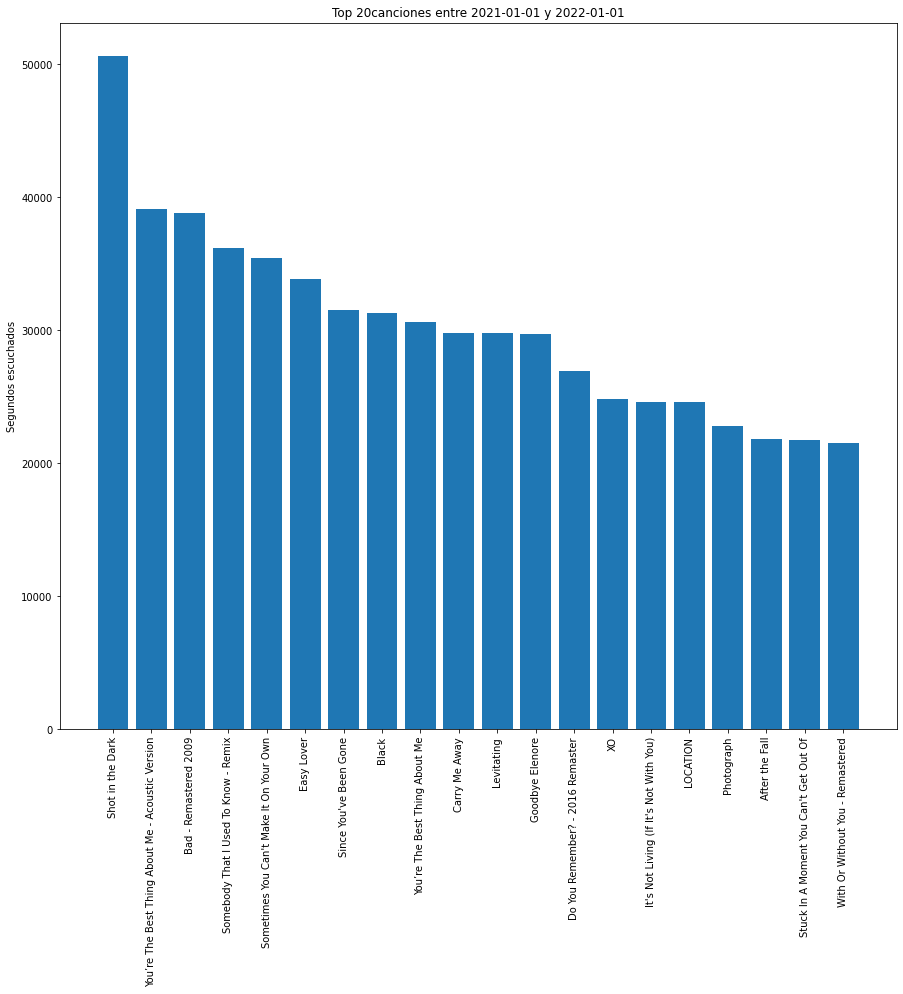

In [ ]:
n = 20
top_canciones = canciones.groupby("cancion").sum(duracion).reset_index().sort_values(by="duracion",ascending=False).head(n)

plt.rcParams["figure.figsize"] = (15,13)
plt.bar([k for k in range(n)],[k/(1000) for k in top_canciones["duracion"]])
plt.xticks( [k for k in range(n)], [k for k in top_canciones["cancion"]] , rotation="vertical")
plt.title("Top "+ str(n) +"canciones entre "+str(fecha_inicial)+" y "+ str(fecha_final))
plt.ylabel("Segundos escuchados")
plt.show()

Segunda gráfica: Top n artistas mas escuchados

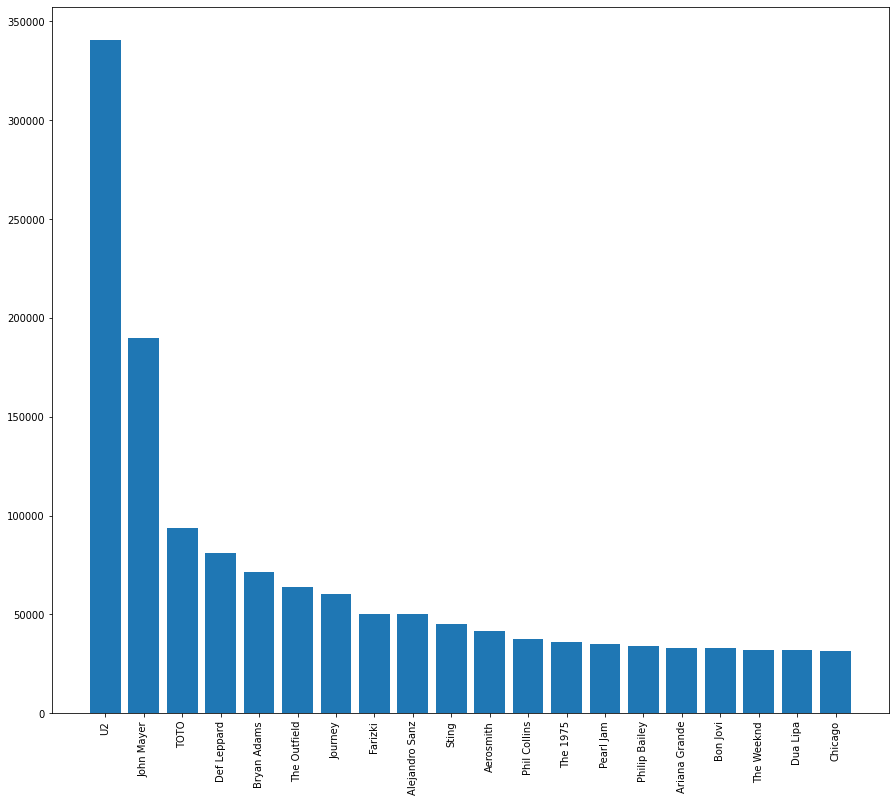

In [ ]:
n = 20
top_artistas = canciones.groupby("artista").sum("duracion").reset_index().sort_values(by="duracion",ascending = False).head(n)

plt.bar([i for i in range(n)], [i/(1000) for i in top_artistas["duracion"]])
plt.xticks([i for i in range(n)], [i for i in top_artistas["artista"]],rotation="vertical")
plt.show()


Gráfica 3: Top n canciones a través del tiempo

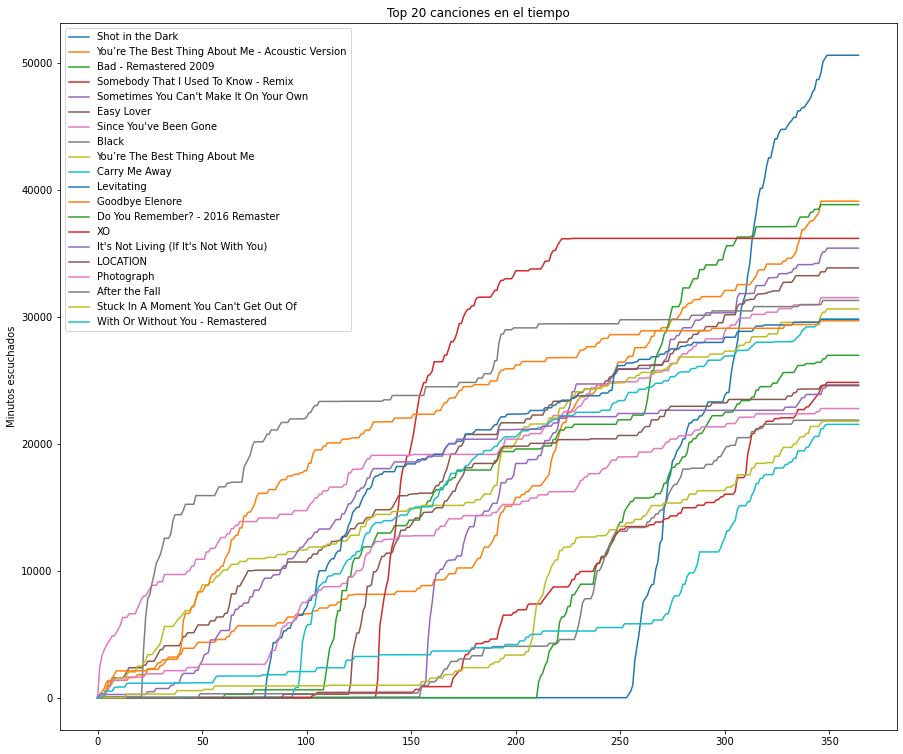

In [ ]:
n = 20
top = [i for i in top_canciones["cancion"]]
top = top[0:n]

index = {}
for i in range(len(top)):
  index[top[i]] = i
fi = fecha_inicial

valores = [[] for i in range(n)]

df_top = canciones[canciones["cancion"].isin(top)]

while(fi < fecha_final):
  dft = df_top[df_top['fecha'] == fi]
  dft = dft.groupby("cancion").sum("duracion").reset_index()
  for i in top:
    if(i in list(dft["cancion"])):
      for j in range(len(dft["cancion"])):
        if(dft["cancion"][j] == i):
          valores[index[i]].append(dft["duracion"][j]/(1000))
    else:
      valores[index[i]].append(0)
  fi = fi + datetime.timedelta(days=1)

for i in range(len(valores)):
  for j in range(len(valores[i])):
    if(j!=0):
      valores[i][j] += valores[i][j-1]   

for i in range(len(valores)):
  plt.plot(valores[i],label=top[i])

plt.legend()
plt.title("Top "+str(n)+" canciones en el tiempo")
plt.ylabel("Minutos escuchados")

plt.show()


Gráfica 4: horas de mayor reproducción de musica

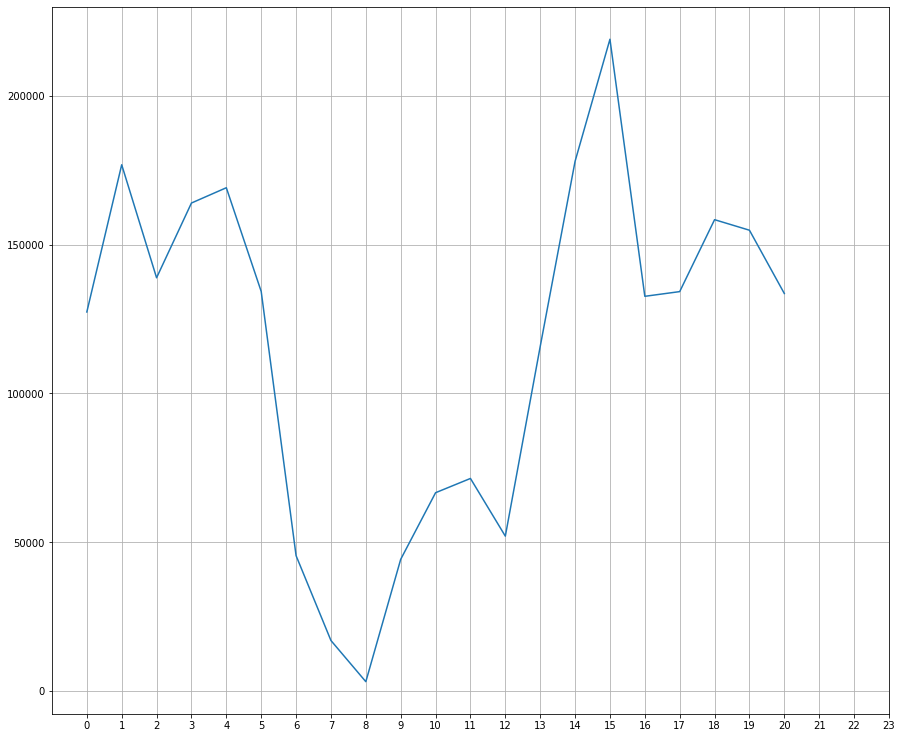

In [ ]:
hora = canciones.groupby("hora").sum("dutation")
hora.reset_index()
plt.plot([i/(1000) for i in hora["duracion"]])
plt.xticks([i for i in range(0,24)], [i for i in range(0,24)] )
plt.grid()
plt.show()

#Encontrar canciones similares

Leer el csv con el registro de las canciones

In [ ]:
bd_spotify = pd.read_csv('/content/drive/MyDrive/Talleres/Análisis de mi spotify/spotify.csv',encoding = "ISO-8859-1")
bd_spotify = bd_spotify[['name','artists',"energy","instrumentalness","liveness","loudness","speechiness","valence"]]
bd_spotify.head()

,name,artists,energy,instrumentalness,liveness,loudness,speechiness,valence
0,Clancy Lowered the Boom,['Dennis Day'],0.341,0.000000,0.160,-12.441,0.4150,0.9630
1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.211,0.878000,0.665,-20.096,0.0366,0.0594
2,The Wearing of the Green,['John McCormack'],0.203,0.000000,0.115,-10.589,0.0615,0.4060
3,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.211,0.878000,0.665,-20.096,0.0366,0.0594
4,When Irish Eyes Are Smiling,['Phil Regan'],0.193,0.000002,0.229,-10.096,0.0380,0.2530


Usar el método .describe()

In [ ]:
bd_spotify.describe()

,energy,instrumentalness,liveness,loudness,speechiness,valence
count,168592.000000,168592.000000,168592.000000,168592.000000,168592.000000,168592.000000
mean,0.488577,0.169476,0.205151,-11.358180,0.083616,0.528497
std,0.267346,0.315383,0.175896,5.670176,0.119917,0.264457
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000
25%,0.265000,0.000000,0.098200,-14.388000,0.034800,0.315000
50%,0.480000,0.000264,0.134000,-10.466000,0.044600,0.539000
75%,0.709000,0.111000,0.259000,-7.135000,0.072300,0.749000
max,1.000000,1.000000,1.000000,3.855000,0.968000,1.000000


Obtener los índices de las canciones que aparecen en el csv (se hace de forma manual)

In [ ]:

l = list(bd_spotify["name"])
en_bd = []
for cancion in top:
  if cancion in l:
    en_bd.append(cancion)

indices = [6189,6300,6593,6865,6990,19095,25643,27277,29291,35154,35430,44573,56998] #se hizo manual
encontradas = bd_spotify.iloc[indices]

encontradas.head()

,name,artists,energy,instrumentalness,liveness,loudness,speechiness,valence
6189,Photograph,['Def Leppard'],0.877,0.635000,0.0551,-6.606,0.0515,0.617
6300,Easy Lover,"['Philip Bailey', 'Phil Collins']",0.923,0.000163,0.0825,-5.082,0.0369,0.930
6593,With Or Without You - Remastered,['U2'],0.429,0.355000,0.1410,-11.822,0.0285,0.113
6865,Do You Remember? - 2016 Remaster,['Phil Collins'],0.509,0.013400,0.0659,-7.472,0.0252,0.525
6990,Black,['Pearl Jam'],0.684,0.000000,0.3400,-6.457,0.0308,0.200


Mi media de datos

In [ ]:
# energy	instrumentalness	liveness	loudness	speechiness	valence
my_mean = list(encontradas.describe().loc["mean"])
my_mean

[0.7262307692307691,
 0.12615629153846153,
 0.13845384615384615,
 -7.049615384615385,
 0.04038461538461538,
 0.4949230769230769]

Metodod de los cosenos

In [ ]:
for i in range(len(bd_spotify["name"])):
  l = list(bd_spotify.loc[i]) [2:]
  valor = np.dot(my_mean,l)/(np.linalg.norm(my_mean) * np.linalg.norm(l))
  if(valor >0.9999):
    print(bd_spotify.iloc[i]["name"],bd_spotify.iloc[i]["artists"])

Jumpin' Jack Flash - Mono Version ['The Rolling Stones']
Stranglehold ['Ted Nugent']
I Wanna Be Adored - Remastered ['The Stone Roses']
Who Do You Love? ['George Thorogood & The Destroyers']
Howlin' for You ['The Black Keys']
Heroes - Single Version; 1990 Remaster ['David Bowie']
Chump ['Green Day']
Me And I ['ABBA']
Scentless Apprentice ['Nirvana']
In the Flat Field ['Bauhaus']
Infected ['The The']
Scentless Apprentice ['Nirvana']
Welcome To This World ['Primus']
Running ['Baby Huey & The Baby Sitters']
Remember Tomorrow - 2015 Remaster ['Iron Maiden']
Twenty Four Hours - 2007 Remaster ['Joy Division']
Mi MuÌ±equita SintÌ©tica ['El HaragÌÁn y CompaÌ±Ì_a']
Por QuÌ© Nos Dijimos AdiÌ_s ['Grupo Yndio']
I Got a Thing, You Got a Thing, Everybody's Got a Thing ['Funkadelic']
Drivin' Wheel ['Foghat']
The Glow - From "The Last Dragon" Soundtrack ['Willie Hutch']
Take Me Home - 2016 Remaster ['Phil Collins']
Scentless Apprentice ['Nirvana']
High-Fiving MF ['Local H']
Who You Are ['Pearl Jam']
W

Metodo de la norma

In [ ]:
my_mean = np.array(my_mean)
for i in range(len(bd_spotify["name"])):
  l = np.array(bd_spotify.loc[i]) [2:]

  valor = np.linalg.norm(my_mean - l)
  if(valor < 0.16):
      print(bd_spotify.iloc[i]["name"],bd_spotify.iloc[i]["artists"])
  

Stranglehold ['Ted Nugent']
Don't Speak ['No Doubt']
Heaven Beside You ['Alice In Chains']
Space Song ['Beach House']
Runaway Train ['Soul Asylum']
I Must Not Think Bad Thoughts ['X']
Strangers Like Me ['Phil Collins']
Suddenly Last Summer ['The Motels']
Lakini's Juice ['Live']
Say OK ['Vanessa Hudgens']
Kiss Somebody ['Morgan Evans']
Bad News ["Whitey Morgan and the 78's"]
To Hell & Back ['Maren Morris']
Since You're Gone - Remastered ['The Cars']
You Gotta Be ["Des'ree"]
Shots - Broiler Remix ['Imagine Dragons', 'Broiler']
Reason To Live ['KISS']
The Veldt - Radio Edit ['deadmau5', 'Chris James']
Tomorrow ['Silverchair']
Rest Stop ['Matchbox Twenty']
I Can Help ['Billy Swan']
Cracks - Flux Pavilion Remix ['The Freestylers', 'Belle Humble', 'Flux Pavilion']
Home ['Dierks Bentley']
It's Love ["King's X"]
Rome ['Phoenix']
KickinÛª Back ['Mila J']
Fast Cars - 1996 Remastered Version ['Buzzcocks']
Born to Run ['Lynyrd Skynyrd']
The Gunslinger ['Shooter Jennings']
The Palisades ['Childish